In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud , STOPWORDS
from nltk import ngrams
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
import re
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# **Load Data**

In [ ]:
data = pd.read_csv("./CSV-Dataset/All Complaint Dataset - All.csv")
alay_dict = pd.read_csv('./CSV-Dataset/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original',
                                      1: 'replacement'})

In [4]:
print(data.shape)
data.head()

(10831, 5)


,link,title,contents,timestamp,labels
0,https://www.lapor.go.id/laporan/detil/penyampa...,Penyampaian Pengaduan Pekerjaan Pengendalian B...,"Probolinggo 2 april 2024 kepada yth, ka.inspek...",11/11/2024 20:49:34,Infrastruktur dan Fasilitas Umum
1,https://www.lapor.go.id/laporan/detil/keluhan-...,Keluhan Pinjaman Online,Lapor pinjaman online yang terdapat pada aplik...,11/11/2024 11:43:00,Teknologi Informasi dan Komunikasi
2,https://www.lapor.go.id/laporan/detil/mohon-pe...,Mohon Perhatian Untuk Lintasan Rel Ka,"Salam, semoga kota pematangsiantar tetap terus...",11/11/2024 20:49:34,Infrastruktur dan Fasilitas Umum
3,https://www.lapor.go.id/laporan/detil/larangan...,Larangan Mudik Masyarakat,"Permisi pak/Bu, saya adalah salah satu mahasis...",11/12/2024 0:35:21,Ketenagakerjaan dan Kesejahteraan Sosial
4,https://www.lapor.go.id/laporan/detil/pencantu...,Pencantuman Gelar Pns,"Yth. kepala bkn salam hormat, saya yang bernam...",11/13/2024 0:12:05,Kepegawaian


# **Drop Duplikat & Missing Data**

In [5]:
data = data.drop(['link', 'timestamp'], axis=1)
data.head()

,title,contents,labels
0,Penyampaian Pengaduan Pekerjaan Pengendalian B...,"Probolinggo 2 april 2024 kepada yth, ka.inspek...",Infrastruktur dan Fasilitas Umum
1,Keluhan Pinjaman Online,Lapor pinjaman online yang terdapat pada aplik...,Teknologi Informasi dan Komunikasi
2,Mohon Perhatian Untuk Lintasan Rel Ka,"Salam, semoga kota pematangsiantar tetap terus...",Infrastruktur dan Fasilitas Umum
3,Larangan Mudik Masyarakat,"Permisi pak/Bu, saya adalah salah satu mahasis...",Ketenagakerjaan dan Kesejahteraan Sosial
4,Pencantuman Gelar Pns,"Yth. kepala bkn salam hormat, saya yang bernam...",Kepegawaian


In [6]:
# Drop data yang contents nya duplikat
print(f'Jumlah data contents duplikat: {data["contents"].duplicated().sum()}')
data = data.drop_duplicates(subset=['contents'], keep='first')

Jumlah data contents duplikat: 116


In [7]:
data['combined'] = data['title'].str.cat(data['contents'], sep=' ')
data[['title', 'contents', 'combined']].head()

,title,contents,combined
0,Penyampaian Pengaduan Pekerjaan Pengendalian B...,"Probolinggo 2 april 2024 kepada yth, ka.inspek...",Penyampaian Pengaduan Pekerjaan Pengendalian B...
1,Keluhan Pinjaman Online,Lapor pinjaman online yang terdapat pada aplik...,Keluhan Pinjaman Online Lapor pinjaman online ...
2,Mohon Perhatian Untuk Lintasan Rel Ka,"Salam, semoga kota pematangsiantar tetap terus...","Mohon Perhatian Untuk Lintasan Rel Ka Salam, s..."
3,Larangan Mudik Masyarakat,"Permisi pak/Bu, saya adalah salah satu mahasis...","Larangan Mudik Masyarakat Permisi pak/Bu, saya..."
4,Pencantuman Gelar Pns,"Yth. kepala bkn salam hormat, saya yang bernam...",Pencantuman Gelar Pns Yth. kepala bkn salam ho...


In [8]:
print(f"Jumlah data title dan contents lainnya yang duplikat: {data['combined'].duplicated().sum()}")
data = data.drop_duplicates(subset=['combined'], keep='first')

Jumlah data title dan contents lainnya yang duplikat: 80


In [9]:
data.shape

(10635, 4)

In [10]:
# Drop data yang contents nya null
null_contents = data['combined'].isnull().sum()
print(f'Jumlah data title+contents null: {null_contents}')
data = data.dropna(subset=['combined'])
print(f'Jumlah data: {data.shape[0]}')

Jumlah data title+contents null: 1
Jumlah data: 10634


# **Exploratory Data Analysis (Sebelum Pre-Processing)**

In [ ]:
# Rata-rata jumlah kata per-data untuk setiap kelas

average_word_counts = data.groupby('labels')['combined'].apply(lambda x: x.str.split().str.len().mean())
average_word_counts

,combined
labels,
Infrastruktur dan Fasilitas Umum,83.217701
Keadilan Hukum dan HAM,476.448232
Kepegawaian,79.214421
Kesehatan,99.633144
Ketenagakerjaan dan Kesejahteraan Sosial,97.065550
Lingkungan Hidup,91.693811
Pendidikan,95.621035
Perizinan dan Pertanahan,111.457475
Teknologi Informasi dan Komunikasi,75.023613


In [ ]:
# Dstribusi data untuk setiap kelas
class_counts = data['labels'].value_counts()
class_counts

,count
labels,
Ketenagakerjaan dan Kesejahteraan Sosial,2090
Kepegawaian,1581
Kesehatan,1412
Pendidikan,1198
Perizinan dan Pertanahan,1117
Infrastruktur dan Fasilitas Umum,983
Teknologi Informasi dan Komunikasi,847
Keadilan Hukum dan HAM,792
Lingkungan Hidup,614


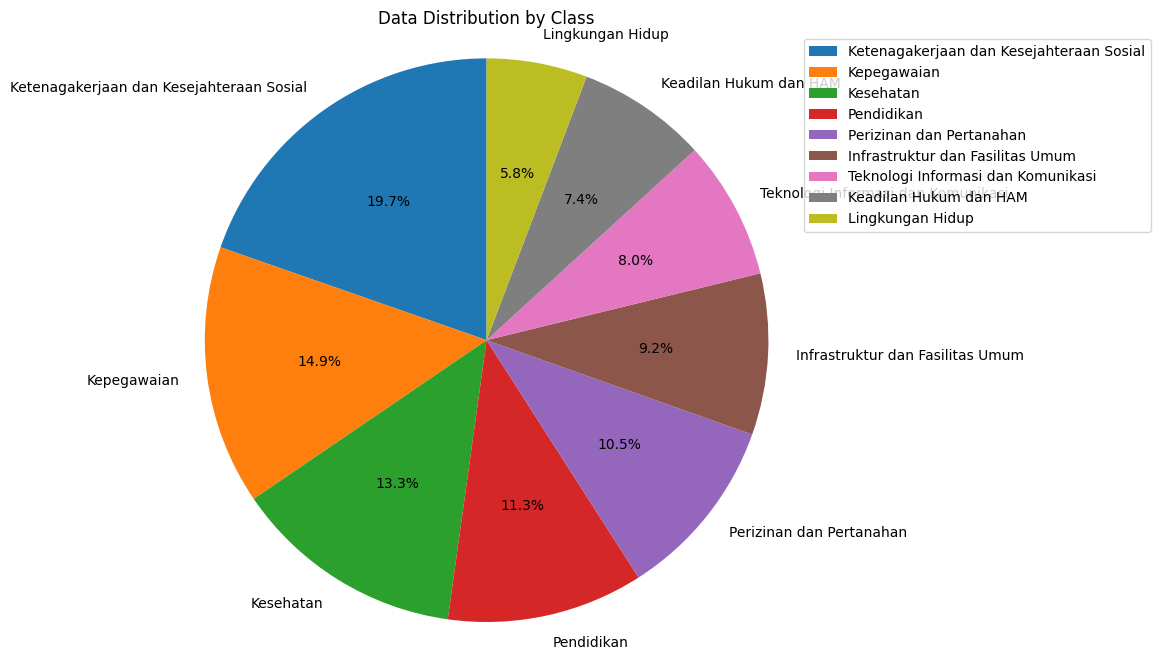

In [ ]:
# Visualisasi distribusi data berdasarkan kelas menggunakan Pie Chart

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Data Distribution by Class')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.axis('equal')
plt.show()

In [ ]:
# Word cloud untuk semua data
all_combined = ' '.join(data['combined'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('All Data')
plt.show()

# Word cloud untuk masing-masing kelas
labels = data['labels'].unique()
num_labels = len(labels)
cols = 3
rows = (num_labels // cols) + (num_labels % cols > 0)  # Hitung jumlah baris

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))

# Flatten axes untuk memudahkan iterasi
axes = axes.flatten()

for i, label in enumerate(labels):
    class_data = data[data['labels'] == label]
    class_combined = ' '.join(class_data['combined'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(class_combined)

    # Plot pada subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'{label}')

# Hapus subplot kosong jika ada
for i in range(len(labels), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

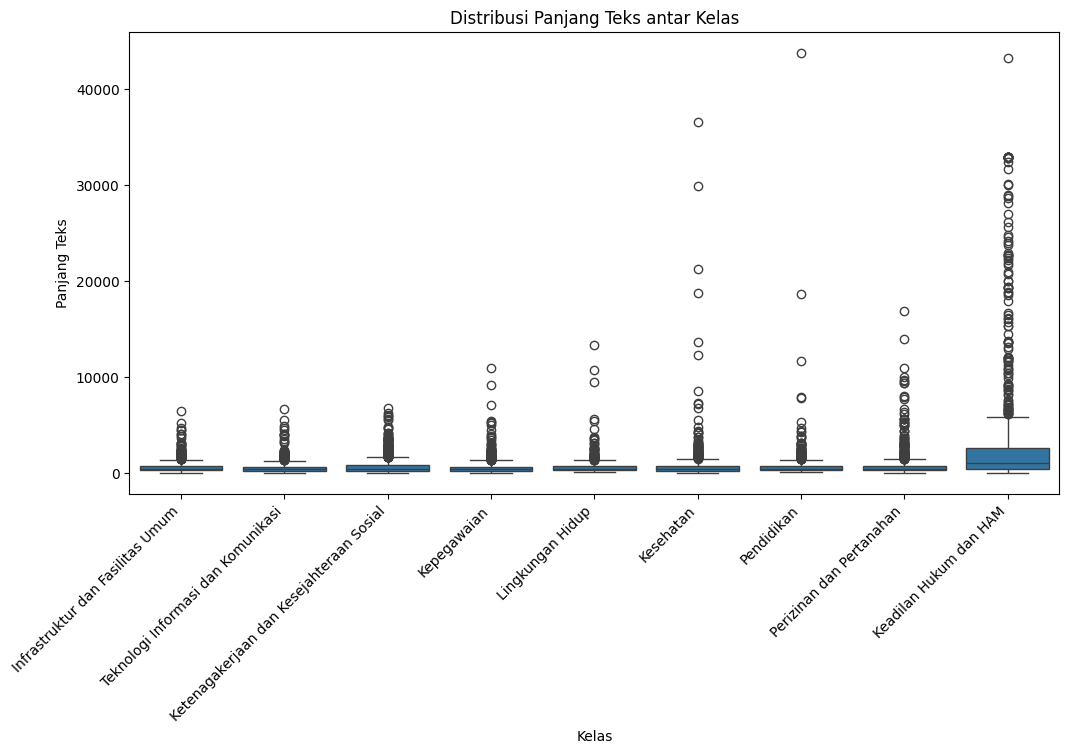

In [ ]:
# Visualisasi panjang teks pada contents berdasarkan kelas

plt.figure(figsize=(12, 6))
sns.boxplot(x='labels', y=data['combined'].apply(lambda x: len(str(x))), data=data)
plt.title('Distribusi Panjang Teks antar Kelas')
plt.xlabel('Kelas')
plt.ylabel('Panjang Teks')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
def analyze_ngrams(text, n):
  tokens = text.lower().split()  # Tokenisasi teks dan konversi ke huruf kecil
  n_grams = list(ngrams(tokens, n))
  return n_grams

text = " ".join(data['contents'].astype(str))

bigrams = analyze_ngrams(text, 2)
trigrams = analyze_ngrams(text, 3)

# Menghitung frekuensi bigrams
bigram_counts = Counter(bigrams)

# Menampilkan 10 bigrams teratas
print("10 Bigrams Teratas:")
for bigram, count in bigram_counts.most_common(10):
    print(bigram, count)


# Menghitung frekuensi trigrams
trigram_counts = Counter(trigrams)

# Menampilkan 10 trigrams teratas
print("\n10 Trigrams Teratas:")
for trigram, count in trigram_counts.most_common(10):
    print(trigram, count)

10 Bigrams Teratas:
('tidak', 'ada') 1871
('hal', 'ini') 1512
('saya', 'ingin') 1372
('yang', 'tidak') 1320
('saat', 'ini') 1264
('terima', 'kasih') 1239
('saya', 'sudah') 1137
('saya', 'tidak') 965
('tidak', 'bisa') 936
('dan', 'tidak') 910

10 Trigrams Teratas:
('hal', 'ini', 'dapat') 451
('sampai', 'saat', 'ini') 415
('komisi', 'iii', 'dpr') 312
('saya', 'ingin', 'melaporkan') 304
('tidak', 'sesuai', 'dengan') 277
('iii', 'dpr', 'ri') 258
('bapak/ibu', 'anggota', 'komisi') 223
('anggota', 'komisi', 'iii') 214
('yang', 'mulia', 'bapak/ibu') 207
('mulia', 'bapak/ibu', 'anggota') 205


Proporsi stopwords rata-rata: 34.18%

Proporsi stopwords berdasarkan kelas:
labels
Infrastruktur dan Fasilitas Umum            29.121530
Keadilan Hukum dan HAM                      34.688816
Kepegawaian                                 33.891326
Kesehatan                                   34.478886
Ketenagakerjaan dan Kesejahteraan Sosial    36.276852
Lingkungan Hidup                            31.748435
Pendidikan                                  35.274210
Perizinan dan Pertanahan                    34.426088
Teknologi Informasi dan Komunikasi          34.299903
Name: stopword_proportion, dtype: float64


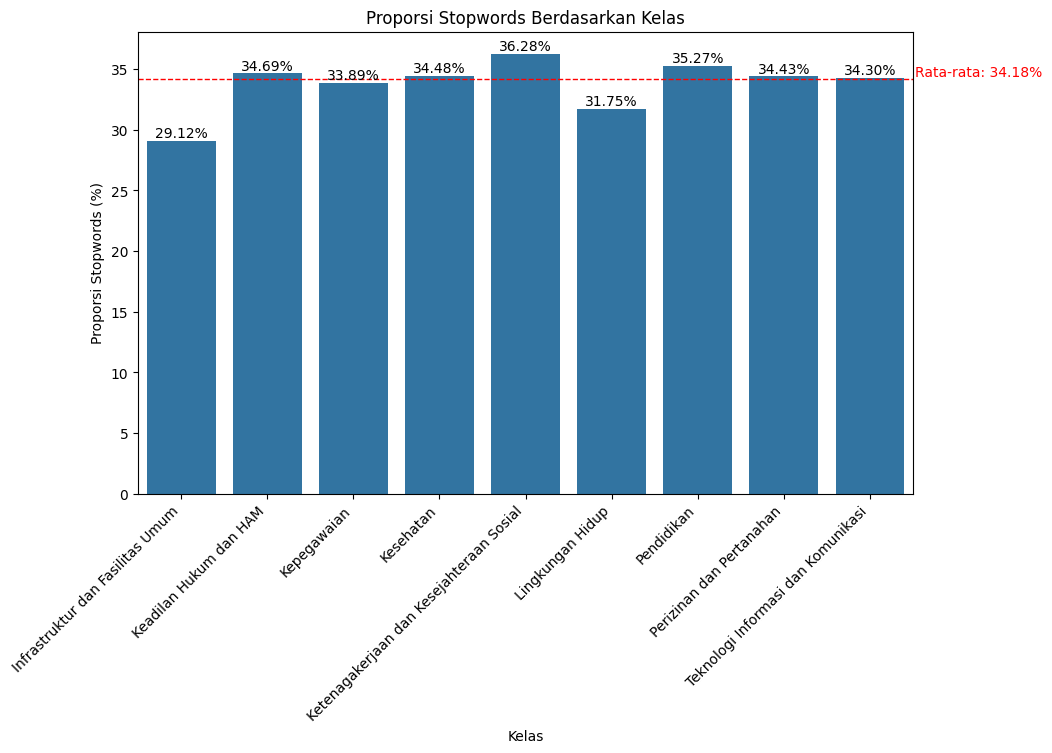

In [ ]:
stop_words = set(stopwords.words('indonesian'))  # Menggunakan stopwords bahasa Indonesia

def identify_stopwords_proportion(text):
  tokens = text.lower().split()
  num_stopwords = sum(1 for token in tokens if token in stop_words)
  total_words = len(tokens)
  stopword_proportion = (num_stopwords / total_words) * 100 if total_words > 0 else 0
  return num_stopwords, total_words, stopword_proportion

data['num_stopwords'], data['total_words'], data['stopword_proportion'] = zip(*data['combined'].apply(identify_stopwords_proportion))

# Analisis proporsi stopwords secara keseluruhan
overall_stopword_proportion = data['stopword_proportion'].mean()
print(f"Proporsi stopwords rata-rata: {overall_stopword_proportion:.2f}%")

# Analisis proporsi stopwords berdasarkan kelas
stopword_proportion_by_class = data.groupby('labels')['stopword_proportion'].mean()
print("\nProporsi stopwords berdasarkan kelas:")
print(stopword_proportion_by_class)

# Visualisasi proporsi stopwords berdasarkan kelas dengan garis rata-rata
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=stopword_proportion_by_class.index, y=stopword_proportion_by_class.values)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.axhline(y=overall_stopword_proportion, color='red', linestyle='--', linewidth=1)
plt.text(ax.get_xlim()[1] + 1.5, overall_stopword_proportion, f'Rata-rata: {overall_stopword_proportion:.2f}%',
         color='red', ha='right', va='bottom')

plt.title('Proporsi Stopwords Berdasarkan Kelas')
plt.xlabel('Kelas')
plt.ylabel('Proporsi Stopwords (%)')
plt.xticks(rotation=45, ha='right')
plt.show()


# **Pre-Processing**

In [ ]:
data.head()

,title,contents,labels,combined,num_stopwords,total_words,stopword_proportion
0,Penyampaian Pengaduan Pekerjaan Pengendalian B...,"Probolinggo 2 april 2024 kepada yth, ka.inspek...",Infrastruktur dan Fasilitas Umum,Penyampaian Pengaduan Pekerjaan Pengendalian B...,62,188,32.978723
1,Keluhan Pinjaman Online,Lapor pinjaman online yang terdapat pada aplik...,Teknologi Informasi dan Komunikasi,Keluhan Pinjaman Online Lapor pinjaman online ...,16,45,35.555556
2,Mohon Perhatian Untuk Lintasan Rel Ka,"Salam, semoga kota pematangsiantar tetap terus...",Infrastruktur dan Fasilitas Umum,"Mohon Perhatian Untuk Lintasan Rel Ka Salam, s...",34,90,37.777778
3,Larangan Mudik Masyarakat,"Permisi pak/Bu, saya adalah salah satu mahasis...",Ketenagakerjaan dan Kesejahteraan Sosial,"Larangan Mudik Masyarakat Permisi pak/Bu, saya...",54,115,46.956522
4,Pencantuman Gelar Pns,"Yth. kepala bkn salam hormat, saya yang bernam...",Kepegawaian,Pencantuman Gelar Pns Yth. kepala bkn salam ho...,37,106,34.905660


In [ ]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z!?,.]+', ' ', text)
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    # Tokenisasi kata agar lebih aman menghapus stopword
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [ ]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text)
    # text = stemming(text)
    text = remove_stopword(text)
    return text

In [ ]:
data['combined'] = data['combined'].apply(preprocess)

In [ ]:
data.head()

,title,contents,labels,combined,num_stopwords,total_words,stopword_proportion
0,Penyampaian Pengaduan Pekerjaan Pengendalian B...,"Probolinggo 2 april 2024 kepada yth, ka.inspek...",Infrastruktur dan Fasilitas Umum,penyampaian pengaduan pekerjaan pengendalian b...,62,188,32.978723
1,Keluhan Pinjaman Online,Lapor pinjaman online yang terdapat pada aplik...,Teknologi Informasi dan Komunikasi,keluhan pinjaman online lapor pinjaman online ...,16,45,35.555556
2,Mohon Perhatian Untuk Lintasan Rel Ka,"Salam, semoga kota pematangsiantar tetap terus...",Infrastruktur dan Fasilitas Umum,mohon perhatian untuk lintasan rel kakak salam...,34,90,37.777778
3,Larangan Mudik Masyarakat,"Permisi pak/Bu, saya adalah salah satu mahasis...",Ketenagakerjaan dan Kesejahteraan Sosial,"larangan mudik masyarakat permisi pak bu, saya...",54,115,46.956522
4,Pencantuman Gelar Pns,"Yth. kepala bkn salam hormat, saya yang bernam...",Kepegawaian,pencantuman gelar pegawai negeri sipil yth. ke...,37,106,34.905660


In [ ]:
# data.to_csv('./CSV-Dataset/without_remove_stopwords/preprocessed_without_remove_stopwords.csv', sep=';', index=False)
data.to_csv('./CSV-Dataset/with_remove_stopwords/preprocessed_with_remove_stopwords.csv', sep=';', index=False)

# **Exploratory Data Analysis (Setelah Pre-Processing)**

In [ ]:
data = pd.read_csv('./CSV-Dataset/with-remove-stopwords/preprocessed_with_remove_stopwords.csv', delimiter=';')
data.head()

,title,contents,labels,combined,num_stopwords,total_words,stopword_proportion
0,Penyampaian Pengaduan Pekerjaan Pengendalian B...,"Probolinggo 2 april 2024 kepada yth, ka.inspek...",Infrastruktur dan Fasilitas Umum,penyampaian pengaduan pekerjaan pengendalian b...,0,134,0.0
1,Keluhan Pinjaman Online,Lapor pinjaman online yang terdapat pada aplik...,Teknologi Informasi dan Komunikasi,keluhan pinjaman online lapor pinjaman online ...,0,29,0.0
2,Mohon Perhatian Untuk Lintasan Rel Ka,"Salam, semoga kota pematangsiantar tetap terus...",Infrastruktur dan Fasilitas Umum,"mohon perhatian lintasan rel kakak salam , sem...",0,64,0.0
3,Larangan Mudik Masyarakat,"Permisi pak/Bu, saya adalah salah satu mahasis...",Ketenagakerjaan dan Kesejahteraan Sosial,"larangan mudik masyarakat permisi bu , salah m...",0,69,0.0
4,Pencantuman Gelar Pns,"Yth. kepala bkn salam hormat, saya yang bernam...",Kepegawaian,pencantuman gelar pegawai negeri sipil yth . k...,0,80,0.0


In [17]:
# Rata-rata jumlah kata per-data untuk setiap kelas

average_word_counts = data.groupby('labels')['combined'].apply(lambda x: x.str.split().str.len().mean())
average_word_counts

,combined
labels,
Infrastruktur dan Fasilitas Umum,63.525941
Keadilan Hukum dan HAM,367.198232
Kepegawaian,58.058191
Kesehatan,70.684844
Ketenagakerjaan dan Kesejahteraan Sosial,68.147368
Lingkungan Hidup,67.765472
Pendidikan,67.282972
Perizinan dan Pertanahan,78.738585
Teknologi Informasi dan Komunikasi,59.547816


In [18]:
data.head()

,title,contents,labels,combined,num_stopwords,total_words,stopword_proportion
0,Penyampaian Pengaduan Pekerjaan Pengendalian B...,"Probolinggo 2 april 2024 kepada yth, ka.inspek...",Infrastruktur dan Fasilitas Umum,penyampaian pengaduan pekerjaan pengendalian b...,0,134,0.0
1,Keluhan Pinjaman Online,Lapor pinjaman online yang terdapat pada aplik...,Teknologi Informasi dan Komunikasi,keluhan pinjaman online lapor pinjaman online ...,0,29,0.0
2,Mohon Perhatian Untuk Lintasan Rel Ka,"Salam, semoga kota pematangsiantar tetap terus...",Infrastruktur dan Fasilitas Umum,"mohon perhatian lintasan rel kakak salam , sem...",0,64,0.0
3,Larangan Mudik Masyarakat,"Permisi pak/Bu, saya adalah salah satu mahasis...",Ketenagakerjaan dan Kesejahteraan Sosial,"larangan mudik masyarakat permisi bu , salah m...",0,69,0.0
4,Pencantuman Gelar Pns,"Yth. kepala bkn salam hormat, saya yang bernam...",Kepegawaian,pencantuman gelar pegawai negeri sipil yth . k...,0,80,0.0


Proporsi stopwords rata-rata: 0.00%

Proporsi stopwords berdasarkan kelas:
labels
Infrastruktur dan Fasilitas Umum            0.0
Keadilan Hukum dan HAM                      0.0
Kepegawaian                                 0.0
Kesehatan                                   0.0
Ketenagakerjaan dan Kesejahteraan Sosial    0.0
Lingkungan Hidup                            0.0
Pendidikan                                  0.0
Perizinan dan Pertanahan                    0.0
Teknologi Informasi dan Komunikasi          0.0
Name: stopword_proportion, dtype: float64


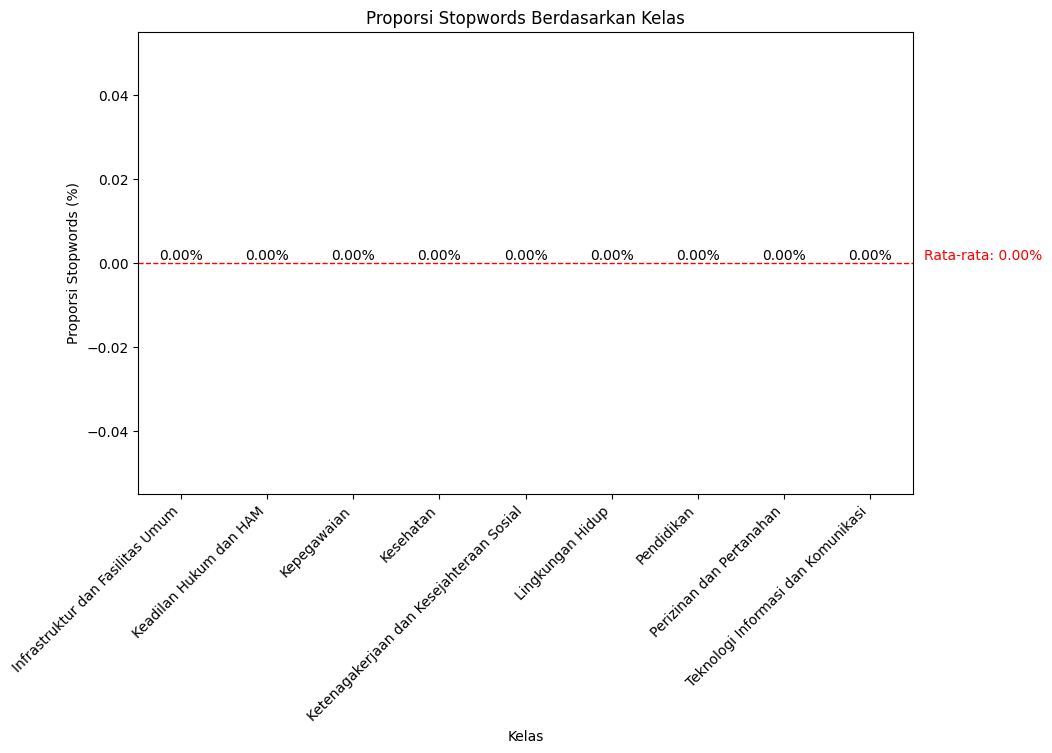

In [19]:
stop_words = set(stopwords.words('indonesian'))  # Menggunakan stopwords bahasa Indonesia

def identify_stopwords_proportion(text):
  tokens = text.lower().split()
  num_stopwords = sum(1 for token in tokens if token in stop_words)
  total_words = len(tokens)
  stopword_proportion = (num_stopwords / total_words) * 100 if total_words > 0 else 0
  return num_stopwords, total_words, stopword_proportion

data['num_stopwords'], data['total_words'], data['stopword_proportion'] = zip(*data['combined'].apply(identify_stopwords_proportion))

# Analisis proporsi stopwords secara keseluruhan
overall_stopword_proportion = data['stopword_proportion'].mean()
print(f"Proporsi stopwords rata-rata: {overall_stopword_proportion:.2f}%")

# Analisis proporsi stopwords berdasarkan kelas
stopword_proportion_by_class = data.groupby('labels')['stopword_proportion'].mean()
print("\nProporsi stopwords berdasarkan kelas:")
print(stopword_proportion_by_class)

# Visualisasi proporsi stopwords berdasarkan kelas dengan garis rata-rata
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=stopword_proportion_by_class.index, y=stopword_proportion_by_class.values)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.axhline(y=overall_stopword_proportion, color='red', linestyle='--', linewidth=1)
plt.text(ax.get_xlim()[1] + 1.5, overall_stopword_proportion, f'Rata-rata: {overall_stopword_proportion:.2f}%',
         color='red', ha='right', va='bottom')

plt.title('Proporsi Stopwords Berdasarkan Kelas')
plt.xlabel('Kelas')
plt.ylabel('Proporsi Stopwords (%)')
plt.xticks(rotation=45, ha='right')
plt.show()

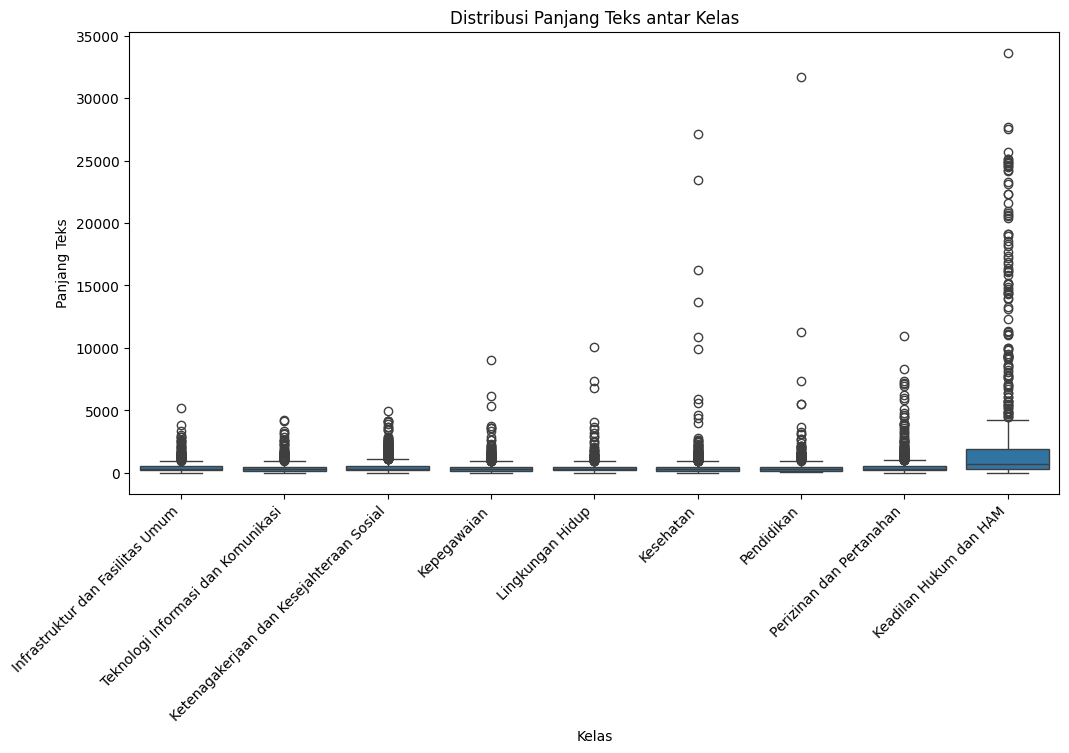

In [20]:
# Visualisasi panjang teks pada contents berdasarkan kelas

plt.figure(figsize=(12, 6))
sns.boxplot(x='labels', y=data['combined'].apply(lambda x: len(str(x))), data=data)
plt.title('Distribusi Panjang Teks antar Kelas')
plt.xlabel('Kelas')
plt.ylabel('Panjang Teks')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
 # Word cloud untuk semua data
all_combined = ' '.join(data['combined'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('All data')
plt.show()

# Word cloud untuk masing-masing kelas
labels = data['labels'].unique()
num_labels = len(labels)
cols = 3
rows = (num_labels // cols) + (num_labels % cols > 0)  # Hitung jumlah baris

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))

# Flatten axes untuk memudahkan iterasi
axes = axes.flatten()

for i, label in enumerate(labels):
    class_data = data[data['labels'] == label]
    class_combined = ' '.join(class_data['combined'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(class_combined)

    # Plot pada subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'{label}')

# Hapus subplot kosong jika ada
for i in range(len(labels), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.